In [1]:
import numpy as np
import sys
import os
import glob
import csv
import re
import time

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline
plt.style.use("seaborn") # plt.style.available

In [3]:
# Globals
datadir = "C:/Users/mholub/data/sicm/2018/11_Nov/26"

In [4]:
# Function defs
def load_result(files = []):
    result = {}
    for f in files:
        name = re.search(exp_name + "_(.*).tsv", os.path.basename(f)).group(1)
        name = name.replace(" ", "")
        with open(f, "r") as rf:
            tsvf = csv.reader(rf, delimiter = "\t")
            for i, row in enumerate(tsvf):
                try:
                    row = np.asarray(list(map(float, filter(None, row))))
                except ValueError as e:
                    import pdb; pdb.set_trace()
                result[name] = row
    print(result.keys())
    num_vals = set(x.shape for x in result.values())
    assert(len(num_vals) <= 1)
    print("Number of datapoints = {}".format(list(num_vals)[0]))
    return(result)

def get_files(datadir, exp_name):
    files = glob.glob(os.path.join(datadir, exp_name + "*.tsv"))
    dates = [os.path.getmtime(f) for f in files]
    t = time.localtime(min(dates))
    date = "{:02d}/{:02d}/{:04d} {:02d}:{:02d}".format(t.tm_mday, t.tm_mon, t.tm_year,
                                                       t.tm_hour, t.tm_min)
    return (files, date)

## Cyclic Voltametry

In [124]:
# Locals
exp_name = "cv2"

In [127]:
files, date = get_files(datadir, exp_name)
result = load_result(files)

dict_keys(['Current1(A)', 'dt(s)', 'LineNumber', 'V1(V)', 'Z(um)'])


Text(0, 0.5, 'LineNumber')

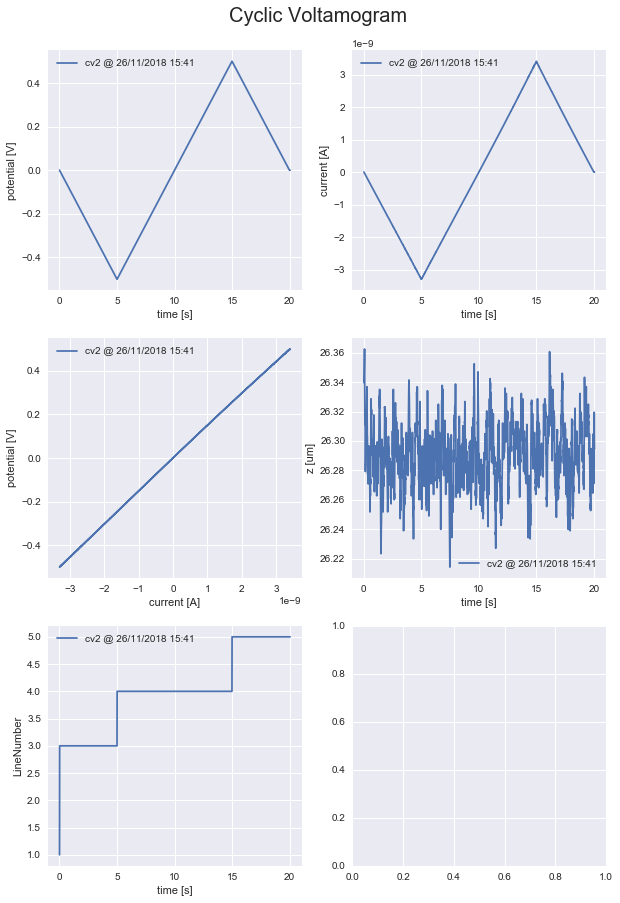

In [128]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
axs = axs.flatten()
fig.suptitle("Cyclic Voltamogram", size = 20, y = 0.92)

axs[0].plot(np.cumsum(result["dt(s)"]), result["V1(V)"])
axs[0].legend(["{} @ {}".format(exp_name, date)])
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("potential [V]")

axs[1].plot(np.cumsum(result["dt(s)"]), result["Current1(A)"])
axs[1].legend(["{} @ {}".format(exp_name, date)])
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("current [A]")

axs[2].plot(result["Current1(A)"], result["V1(V)"])
axs[2].legend(["{} @ {}".format(exp_name, date)])
axs[2].set_xlabel("current [A]")
axs[2].set_ylabel("potential [V]")

axs[3].plot(np.cumsum(result["dt(s)"]), result["Z(um)"])
axs[3].legend(["{} @ {}".format(exp_name, date)])
axs[3].set_xlabel("time [s]")
axs[3].set_ylabel("z [um]")

axs[4].plot(np.cumsum(result["dt(s)"]), result["LineNumber"])
axs[4].legend(["{} @ {}".format(exp_name, date)])
axs[4].set_xlabel("time [s]")
axs[4].set_ylabel("LineNumber")


# not used
# xticks = ax.get_xticks(); xmin = np.min(xticks); xmax = np.max(xticks);
# yticks = ax.get_yticks(); ymin = np.min(yticks); ymax = np.max(yticks);
# ax.set_xticks(np.arange(xmin, xmax,  (xmax-xmin) / 10))
# ax.set_yticks(np.arange(ymin, ymax,  (ymax-ymin) / 10))

## Hopping Scan

In [5]:
import copy
#Function Defs
def downsample_to_linenumber(result = {}, lineno = -1, which = "last"):
    result_out = copy.deepcopy(result)
    if not isinstance(lineno, (list, tuple, np.ndarray)): 
        lineno = [lineno]
    if lineno[0] < 0:
        return result_out
    
    assert "LineNumber" in result.keys()
    assert "dt(s)" in result.keys()
    
    tf = np.isin(result["LineNumber"], lineno)
    tf_diff = np.diff(tf.astype(np.int))
    
    if which == "last":
        idx = np.argwhere(tf_diff == -1)
    elif which == "first":
        idx = np.argwhere(tf_diff == 1)
    else:
        idx = np.argwhere(tf)
    
    for k,v in result.items():
        if k == "dt(s)":
            result_out["time(s)"] = np.cumsum(v)[idx]
        else:
            result_out[k] = v[idx]
        
    print("Number of datapoints = {}".format(len(idx)))
        
    return(result_out)

def trim_from_start(result = {}, lineno = -1):
    if not isinstance(lineno, (list, tuple, np.ndarray)): 
        lineno = [lineno]
    if lineno[0] < 0:
        return result
    
    assert "LineNumber" in result.keys()
    tf = np.isin(result["LineNumber"], lineno)
    
    for k,v in result.items():
        result[k] = v[tf]
        
    print("Number of datapoints = {}".format(sum(tf)))
        
    return(result)

In [6]:
# Locals
exp_name = "scan3"

In [7]:
files, date = get_files(datadir, exp_name)
result_ = load_result(files)

dict_keys(['Current1(A)', 'dt(s)', 'LineNumber', 'V1(V)', 'X(um)', 'Y(um)', 'Z(um)'])
Number of datapoints = (1094048,)


In [15]:
uniqs, cnts = np.unique(result_["LineNumber"], return_counts=True)
linenos = np.arange(4, max(uniqs), 3)
result = downsample_to_linenumber(result_, linenos, which = "first")
# TODO: Here you need a way how to pull out last occurence of the the element
# with line number 5+3

Number of datapoints = 2916


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[    1 13425    13     2   351    13     2   366    13     2   342    13
     2   347    13]


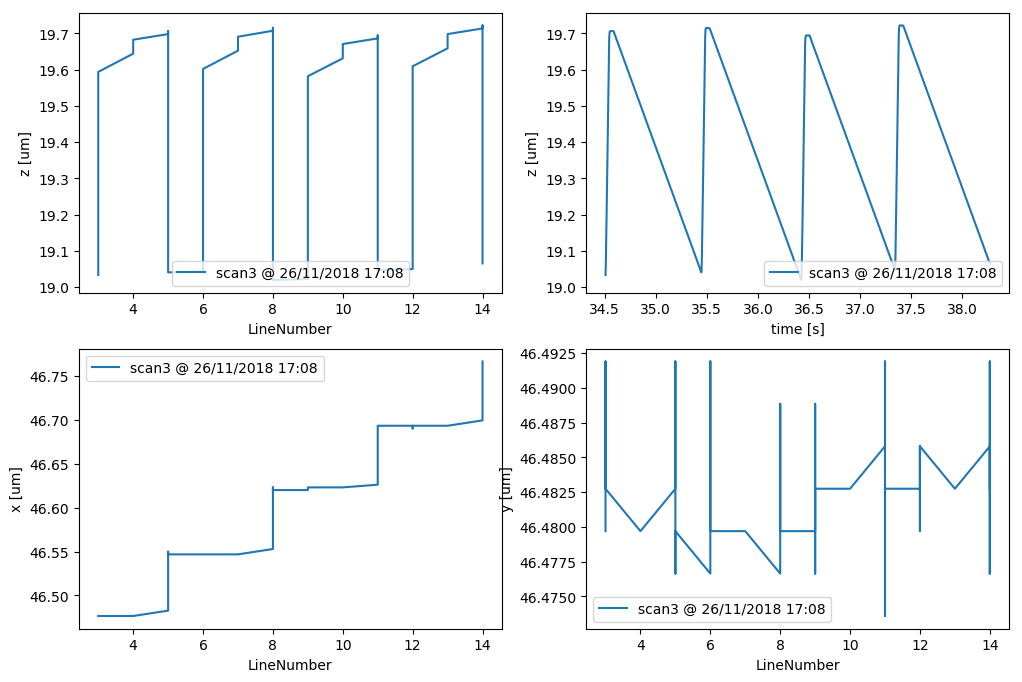

In [16]:
fig, axs = plt.subplots(2, 2, squeeze=False, figsize = (12, 8))
axs = axs.flatten()

sel = np.arange(13426, 13426+13+2+351+13+2+366+13+2+342+13+2+347)

x = result_["LineNumber"][sel]
y = result_["Z(um)"][sel]
axs[0].plot(x, y)
axs[0].legend(["{} @ {}".format(exp_name, date)])
axs[0].set_xlabel("LineNumber")
axs[0].set_ylabel("z [um]")

x = np.cumsum(result_["dt(s)"])[sel]
y = result_["Z(um)"][sel]
axs[1].plot(x, y)
axs[1].legend(["{} @ {}".format(exp_name, date)])
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("z [um]")

x = result_["LineNumber"][sel]
y = result_["X(um)"][sel]
axs[2].plot(x, y)
axs[2].legend(["{} @ {}".format(exp_name, date)])
axs[2].set_xlabel("LineNumber")
axs[2].set_ylabel("x [um]")

x = result_["LineNumber"][sel]
y = result_["Y(um)"][sel]
axs[3].plot(x, y)
axs[3].legend(["{} @ {}".format(exp_name, date)])
axs[3].set_xlabel("LineNumber")
axs[3].set_ylabel("y [um]")

print(uniqs[0:15])
print(cnts[0:15])

Text(0, 0.5, 'y [um]')

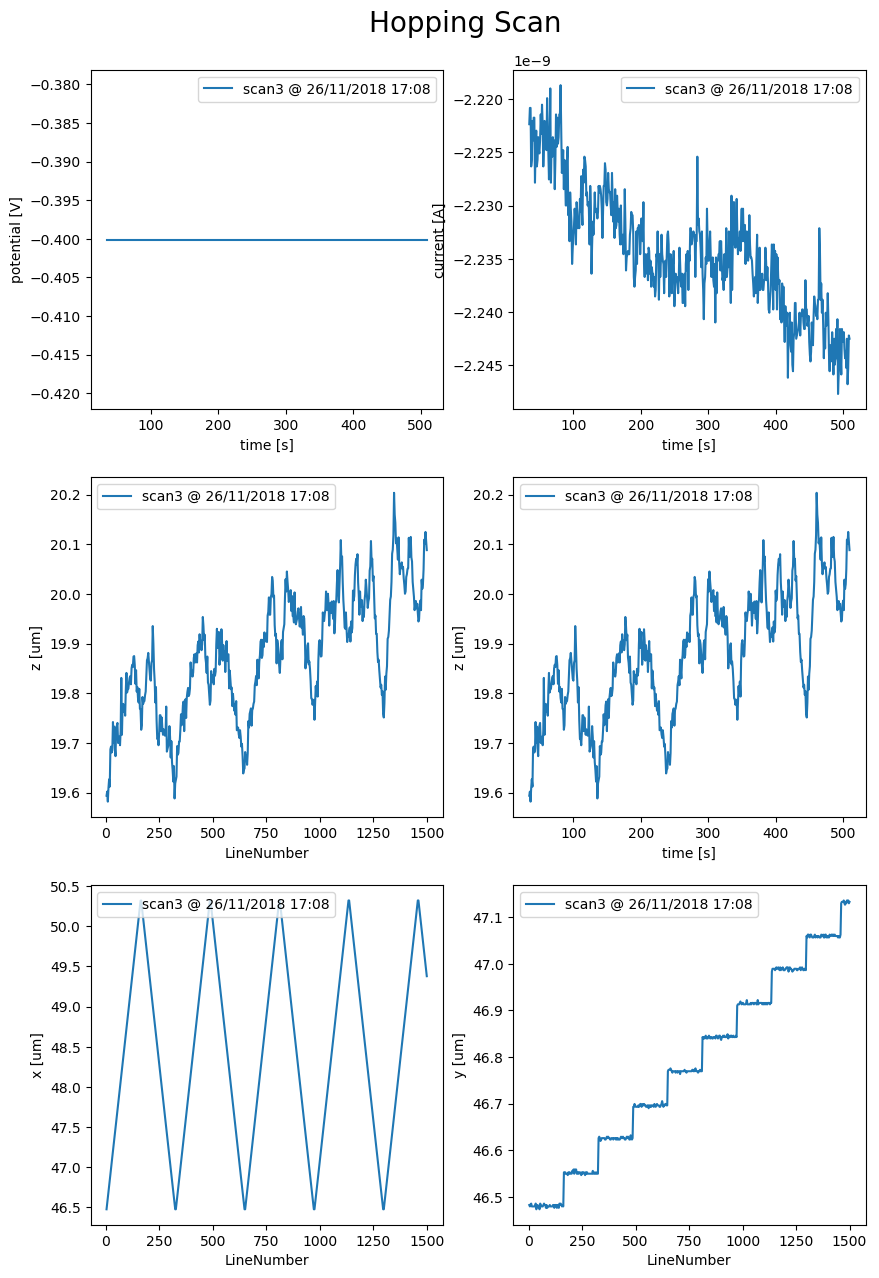

In [17]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
axs = axs.flatten()
fig.suptitle("Hopping Scan", size = 20, y = 0.92)

sel = np.arange(0, 500)

axs[0].plot(result["time(s)"][sel], result["V1(V)"][sel])
axs[0].legend(["{} @ {}".format(exp_name, date)])
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("potential [V]")

axs[1].plot(result["time(s)"][sel], result["Current1(A)"][sel])
axs[1].legend(["{} @ {}".format(exp_name, date)])
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("current [A]")

axs[2].plot(result["LineNumber"][sel], result["Z(um)"][sel])
axs[2].legend(["{} @ {}".format(exp_name, date)])
axs[2].set_xlabel("LineNumber")
axs[2].set_ylabel("z [um]")

axs[3].plot(result["time(s)"][sel], result["Z(um)"][sel])
axs[3].legend(["{} @ {}".format(exp_name, date)])
axs[3].set_xlabel("time [s]")
axs[3].set_ylabel("z [um]")

# axs[4].plot(result["time(s)"], result["LineNumber"])
# axs[4].legend(["{} @ {}".format(exp_name, date)])
# axs[4].set_xlabel("time [s]")
# axs[4].set_ylabel("LineNumber")


axs[4].plot(result["LineNumber"][sel],  result["X(um)"][sel])
axs[4].legend(["{} @ {}".format(exp_name, date)])
axs[4].set_xlabel("LineNumber")
axs[4].set_ylabel("x [um]")

axs[5].plot(result["LineNumber"][sel],  result["Y(um)"][sel])
axs[5].legend(["{} @ {}".format(exp_name, date)])
axs[5].set_xlabel("LineNumber")
axs[5].set_ylabel("y [um]")

In [32]:
plt.style.use("default")
var = result
X = np.reshape(var["X(um)"], [np.int(np.sqrt(len(var["X(um)"])))]*2)
Y = np.reshape(var["Y(um)"], [np.int(np.sqrt(len(var["Y(um)"])))]*2)
Z = np.reshape(var["Z(um)"], [np.int(np.sqrt(len(var["Z(um)"])))]*2).T

<IPython.core.display.Javascript object>


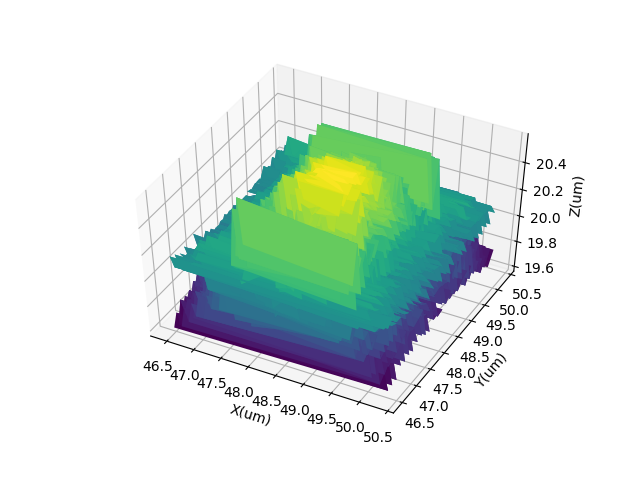

Text(0.5, 0, 'Z(um)')

In [33]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1,)
# ax.contour(X,Y, Z)

# X, Y = np.meshgrid(result["X(um)"],  result["Y(um)"])
# Z = result["Z(um)"]

from mpl_toolkits import mplot3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot_surface(X, Y, Z, 
                rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('X(um)')
ax.set_ylabel('Y(um)')
ax.set_zlabel('Z(um)')